# Third algorithm


In [551]:
from scipy.stats import norm, probplot
# Calculate the 95th percentile
percentile_95 = norm.ppf(0.95, loc=0, scale=1)
percentile_95

np.float64(1.644853626951472)

In [39]:
from app_hawkes import *
import numpy as np


def diagonal_up_weighting(spectral_matrices, zeta):
    """
    Apply the matrix diagonal up-weighting scheme to an array of spectral matrices.

    Parameters:
    spectral_matrices (numpy.ndarray): Array of spectral matrices with shape (p, p, num_frequencies)
    zeta (float): Up-weighting parameter

    Returns:
    numpy.ndarray: New array of up-weighted spectral matrices
    """
    # Matrix dimensions and number of frequencies
    p, _, num_frequencies = spectral_matrices.shape

    # Step 1: Evaluate the maximum value of each diagonal element over the frequency range
    max_diagonal_elements = np.max([spectral_matrices[i, i, :] for i in range(p)], axis=1)
    
    # Step 2: Arrange the maximum values into a diagonal matrix A
    A = np.diag(max_diagonal_elements)
    
    # Step 3: Multiply A by zeta to get B
    B = zeta * A
    
    # Step 4: Add B to each spectral matrix
    new_spectral_matrices = spectral_matrices + B[:, :, np.newaxis]

    return new_spectral_matrices

def calculate_critical_region_minmax(alpha, L, l, n, p):
    """
    Calculate the critical region for partial coherence estimator.

    Parameters:
    alpha (float): Significance level.
    L (int): Total number of frequency bins.
    l (int): Current frequency bin index (1-based).
    n (int): Number of complex degrees of freedom.
    p (int): Number of time series.

    Returns:
    float: The critical value C_l.
    """
    # Calculate the critical region value C_l using the provided formula (19)
    exponent = 1 / (L - l + 1)
    base = 1 - alpha
    inner_term = 1 - base ** exponent
    critical_value = 1 - (inner_term ** (1 / (n - p + 1)))

    return critical_value

def calculate_critical_region_holm(alpha, L, l, n, p):
    """
    Calculate Holm's critical region for multiple hypothesis testing.

    Parameters:
    alpha (float): Significance level.
    L (int): Total number of tests (frequency bins).
    l (int): Current test index (1-based).
    n (int): Number of complex degrees of freedom.
    p (int): Number of time series.

    Returns:
    float: Holm's critical value for the given test index.
    """
    fraction = alpha / (L - l + 1)
    holm_critical_value = 1 - (fraction) ** (1/(n - p + 1))
    return holm_critical_value

def maximin_stepdown_test(partial_coherence, alpha, n):
    """
    Perform the maximin stepdown hypothesis testing procedure.

    Parameters:
    coherence_matrix (numpy.ndarray): Coherence matrix with shape (p, p, num_freq).
    alpha (float): Significance level.
    n (int): Number of complex degrees of freedom (tapers)
    p (int): Number of time series.
    m (int): Number of tapers.

    Returns:
    int: Number of hypotheses under the critical value.
    """
    num_series, _, num_frequencies = partial_coherence.shape
    
    
    # Initialize an array to store the critical values for each frequency bin
    critical_values = np.zeros(num_frequencies)
    
    array = np.arange(num_frequencies)
    
    # Calculate critical values for each frequency bin
    for l in range(1, num_frequencies + 1):
        critical_values[l - 1] = calculate_critical_region_minmax(alpha, num_frequencies, l, n, num_series)
        
    critical_values_holm = np.zeros(num_frequencies)
    # Calculate critical values for each frequency bin
    for l in range(1, num_frequencies + 1):
        critical_values_holm[l - 1] = calculate_critical_region_holm(alpha, num_frequencies, l, n, num_series)
        
    final = dict()
    
    # Define the number of subplots per row and columns
    num_columns = 3
    num_rows = 1#(num_series * (num_series - 1)) // num_columns + 1
    
    # Create figure with larger size
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5))
    
    # Flatten the axs array if there's only one row
    if num_rows == 1:
        axs = axs.reshape(1, -1)

    # Loop over pairs of indices (j, k)
    for j in range(num_series):
        for k in range(j + 1, num_series):  # Only consider upper triangular entries (j < k)
            R_l = partial_coherence[j, k, :]
            R_ordered = np.sort(R_l)[::-1]
            comparison = R_ordered > critical_values  # Check where R_ordered is greater than critical_values
            comparison = np.sum(comparison)
            final[(j, k)] = np.round(comparison / num_frequencies, 2)
    
            # Calculate subplot position
            subplot_index = (j * (num_series - 1)) + (k - j) - 1 
    
            # Plot on the corresponding axis
            ax = axs[subplot_index // num_columns, subplot_index % num_columns]
            ax.plot(array, R_ordered, label="Partial Coherence")
            ax.plot(array, critical_values, label="Critical regions (independent)")
            ax.plot(array, critical_values_holm, label="Critical regions (HOLM)")
            ax.set_title(f"Edge ({j},{k})")
    
    # Adjust layout and legend
    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at the top for the legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=3)  # Place legend at the top
    
    # Show the plot
    plt.show()

    return final

def temporary_third_algoritm(A_list, T, alpha=0.05):
    # Generate time series
    x = generate_var_process(A_list, T, 1000, seed=None)
    x = x - np.mean(x, axis=1, keepdims=True)
    
    _, periodogram = calculate_periodogram(x)
    
    m_list = [10, 30, 50, 100, 200]
    T_0_list = []
    partial_coherence_list = []
    for m in m_list:
        print(f"M value: {m}")
        frequencies, T_0 = sinusoidal_multitaper_sdf_matrix(x, m)
        T_0_list.append(T_0)
        part_coherence = calculate_partial_coherence(T_0)
        partial_coherence_list.append(part_coherence)
        answer = maximin_stepdown_test(part_coherence, alpha, m)
        print(np.real(answer))
        print('------')
        
    return T_0_list, partial_coherence_list, periodogram, frequencies

In [ ]:
# Constants
C = 0.617
D = 0.446
# D = 0.761
m1 = 0
m2 = 1
num_iter = 10
alpha = 0.05
T = 2048

# A_list = [np.array([
#     [0.5, 0.0, 0.2],
#     [0.0, 0.5, 0.2],
#     [0.2, 0.2, 0.5]
# ])]

# A_list = [np.array([
#     [0.5, 0.49, 0.0, 0.0, 0.0],
#     [0.49, 0.5, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.5, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.5, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.5]
#     ])]
# 
# is_var_process_stationary(A_list)


X = 0.0
# 
A_list = [np.array([
    [0.2, 0.0, 0.3, 0.0, 0.3],
    [0.3, -0.2, X, 0.0, 0.0],
    [0.2, X, 0.3, 0.0, 0.0],
    [0.2, 0.2, 0.0, 0.3, 0.0],
    [0.2, 0.0, 0.2, 0.2, 0.2]
])]

In [105]:
# Generate time series
x = generate_var_process(A_list, T, 1000, seed=None)
x = x - np.mean(x, axis=1, keepdims=True)
freq, periodogram = calculate_periodogram(x)

In [102]:
# Periodogram
def calculate_periodogram(X, taper=None, noise_level=1e-10):
    """
    Calculate the power spectral density matrix \hat{S}^{(P)}(f) for a given time series matrix X,
    with added noise to ensure the matrix is not singular.

    Parameters:
    X (numpy.ndarray): A 2D array where each row represents a time series.
    taper (numpy.ndarray): A 1D array to be multiplied element-wise to each time series.
    noise_level (float): The standard deviation of the Gaussian noise to be added.

    Returns:
    S_P (numpy.ndarray): The power spectral density matrix for each frequency.
    frequencies (numpy.ndarray): The frequency bins corresponding to the power spectral density.
    """
    N = X.shape[1]  # Number of time steps
    sqrt_N = np.sqrt(N)

    # Apply taper to each time series if provided
    if taper is not None:
        if taper.shape[0] != N:
            raise ValueError("The taper vector must have the same length as the time series.")
        X = X * taper
    else:
        X = X * 1 / sqrt_N

    # Compute the FFT for each time series
    W = np.fft.fft(X, axis=1)[:, :N // 2]

    # Add small Gaussian noise to W to avoid singularity
    # noise = np.random.normal(scale=noise_level, size=W.shape)
    # W += noise

    # Compute the frequencies
    frequencies = np.fft.fftfreq(N)[:N // 2]

    # Initialize the power spectral density matrix
    S_P = np.zeros((X.shape[0], X.shape[0], N // 2), dtype=np.complex128)

    # Calculate the power spectral density matrix for each frequency
    for i in range(N // 2):
        W_f = W[:, i]  # FFT values for the ith frequency
        S_P[:, :, i] = np.outer(W_f, np.conj(W_f).T)  # W(f) * W^H(f)

    return frequencies, S_P

In [109]:
q = 0
for i in range( 512):
    q += 1
    
print(q)

512


M value: 10


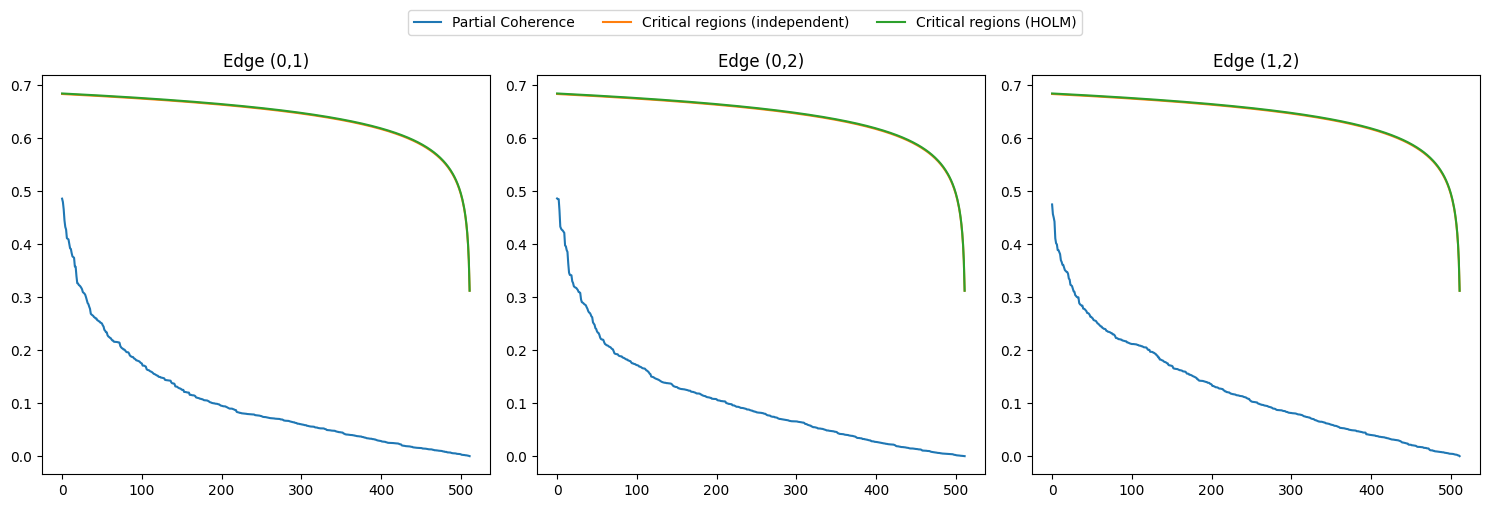

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.0), (1, 2): np.float64(0.0)}
------
M value: 30


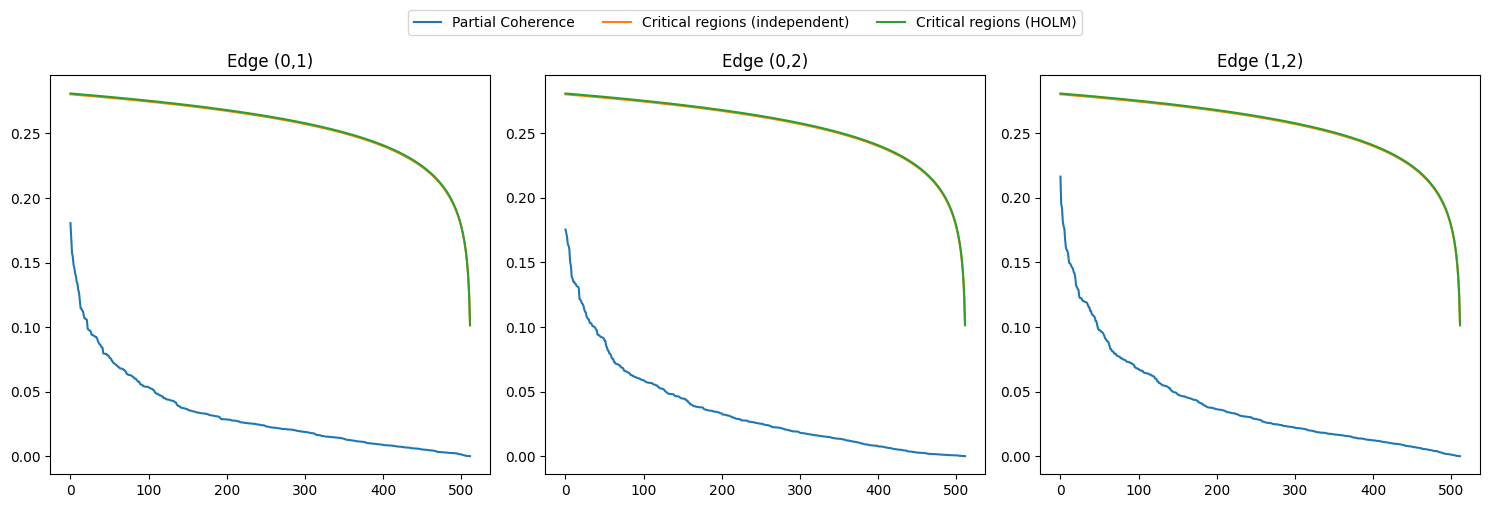

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.0), (1, 2): np.float64(0.0)}
------
M value: 50


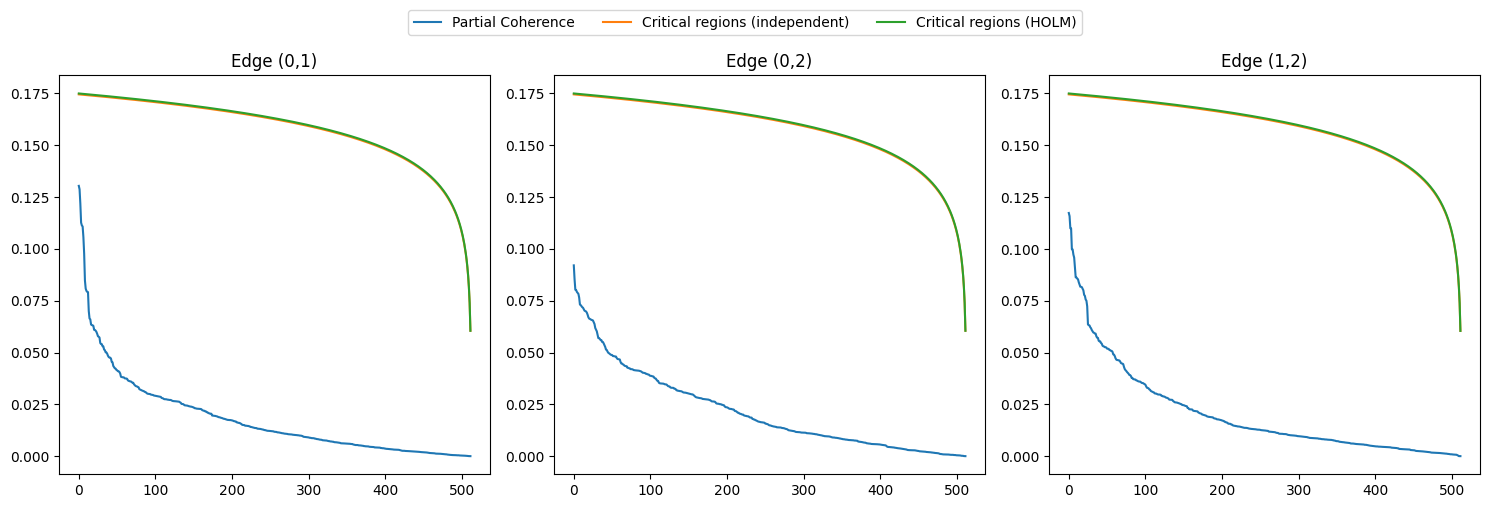

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.0), (1, 2): np.float64(0.0)}
------
M value: 100


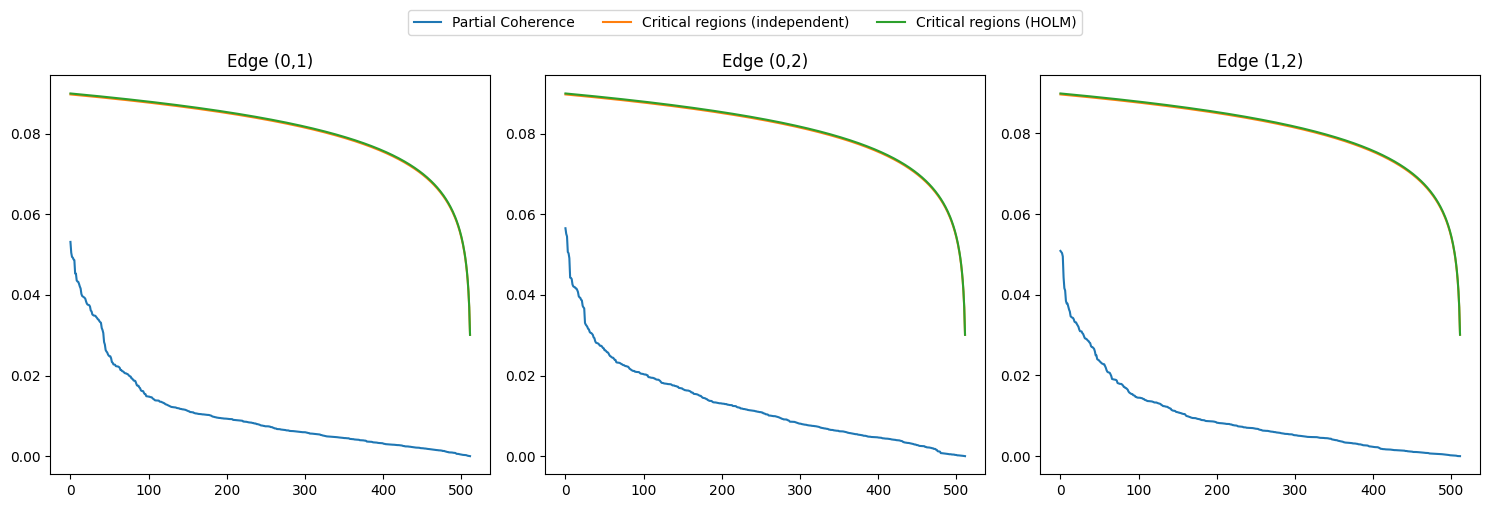

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.0), (1, 2): np.float64(0.0)}
------
M value: 200


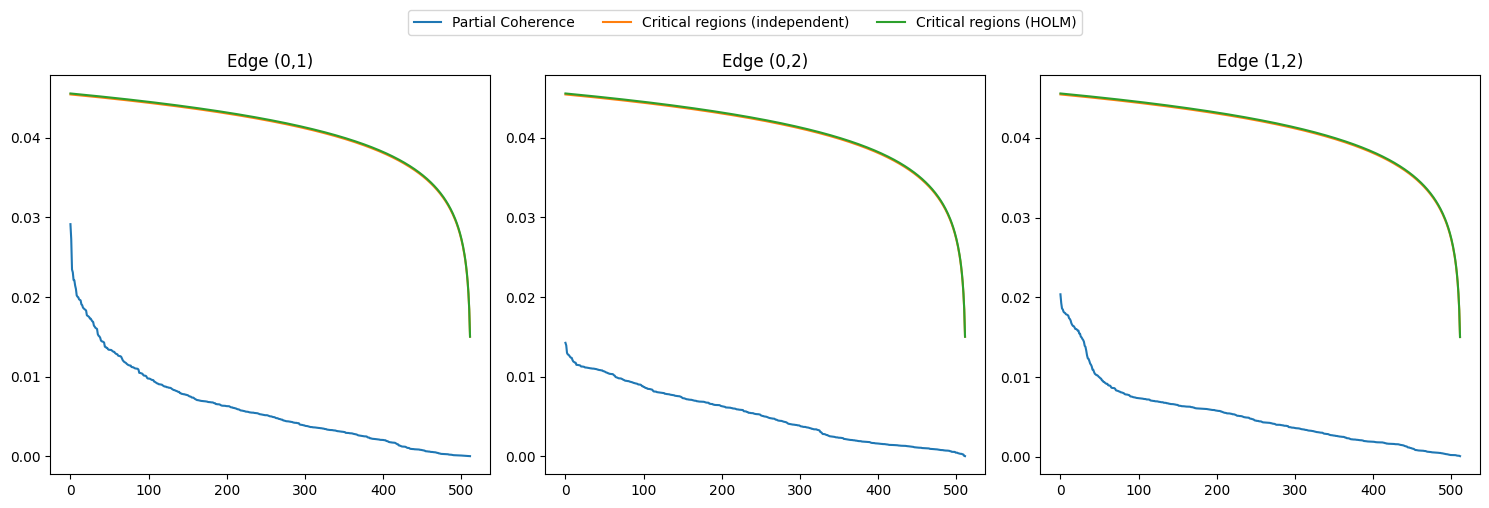

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.0), (1, 2): np.float64(0.0)}
------


In [491]:
A_list = [np.array([
    [0.5, 0.0, 0.0],
    [0.0, 0.5, -0.0],
    [0.0, -0.0, 0.5]
])]

T = 1024
alpha = 0.05
m_list = [10, 30, 50, 100, 200]

# Transform each element to the desired format
names = [f'm={m}' for m in m_list]
names = ['Periodogram'] + names
T_0_list, partial_coherence_list, periodogram, frequencies = temporary_third_algoritm(A_list, T, alpha=alpha)

In [ ]:
plot_sdf_with_theoretical(frequencies,[periodogram] + T_0_list, names, theoretical_sdf=None, log_scale=False,
                          function=np.abs, different_frequencies=None)

In [ ]:
# coherence_P = calculate_partial_coherence(periodogram)
plot_sdf_with_theoretical(frequencies, partial_coherence_list, names[1:], theoretical_sdf=None, log_scale=False,
                          function=np.abs, different_frequencies=None)

# T=10240

M value: 10


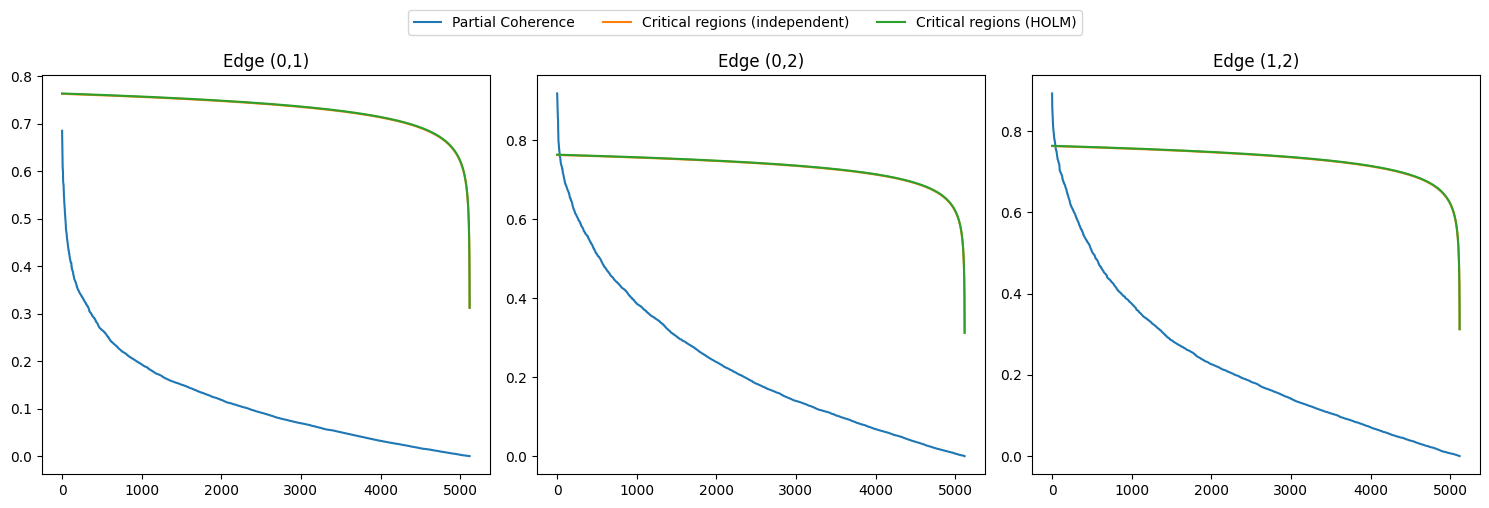

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.01), (1, 2): np.float64(0.01)}
------
M value: 30


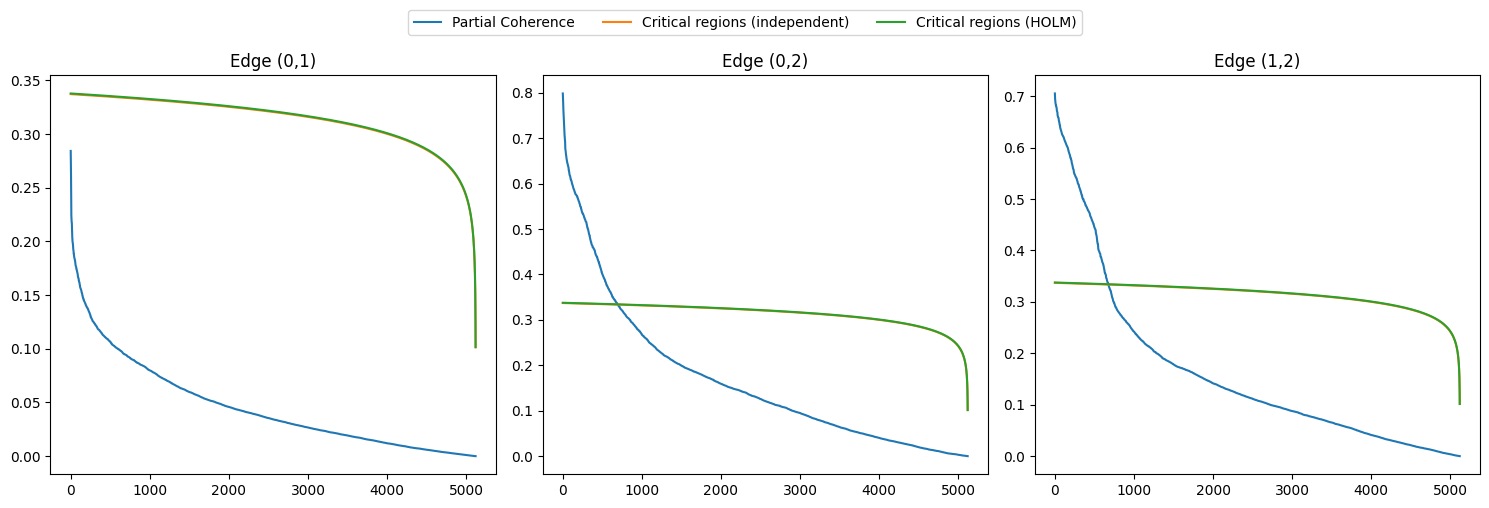

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.14), (1, 2): np.float64(0.13)}
------
M value: 50


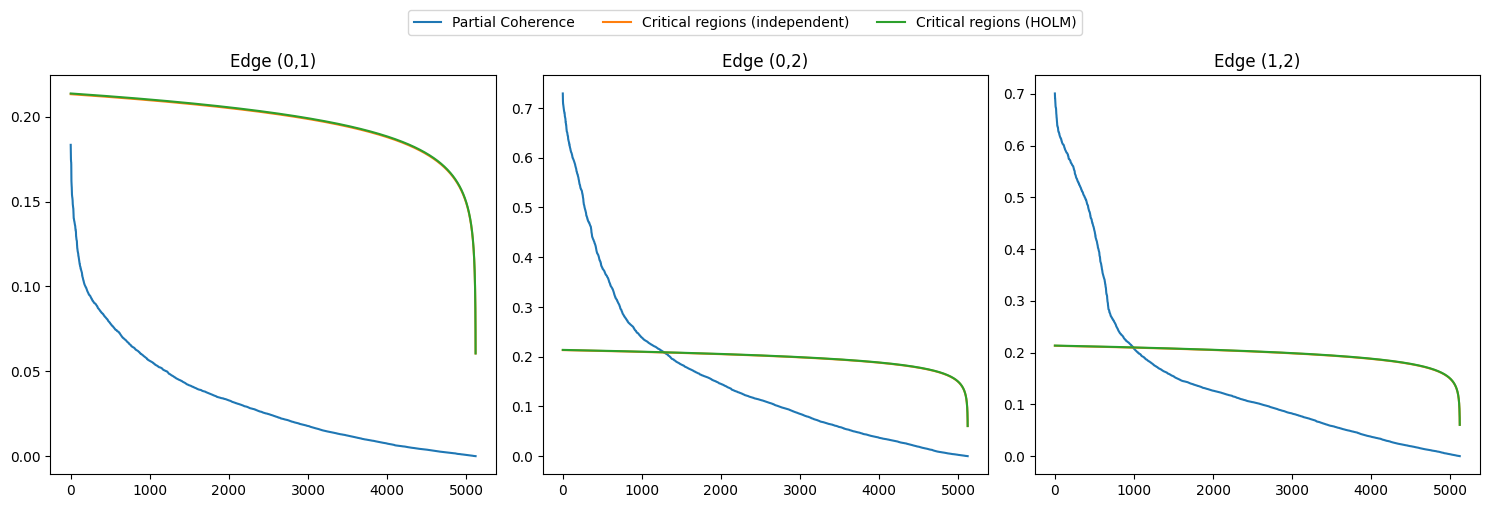

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.25), (1, 2): np.float64(0.19)}
------
M value: 100


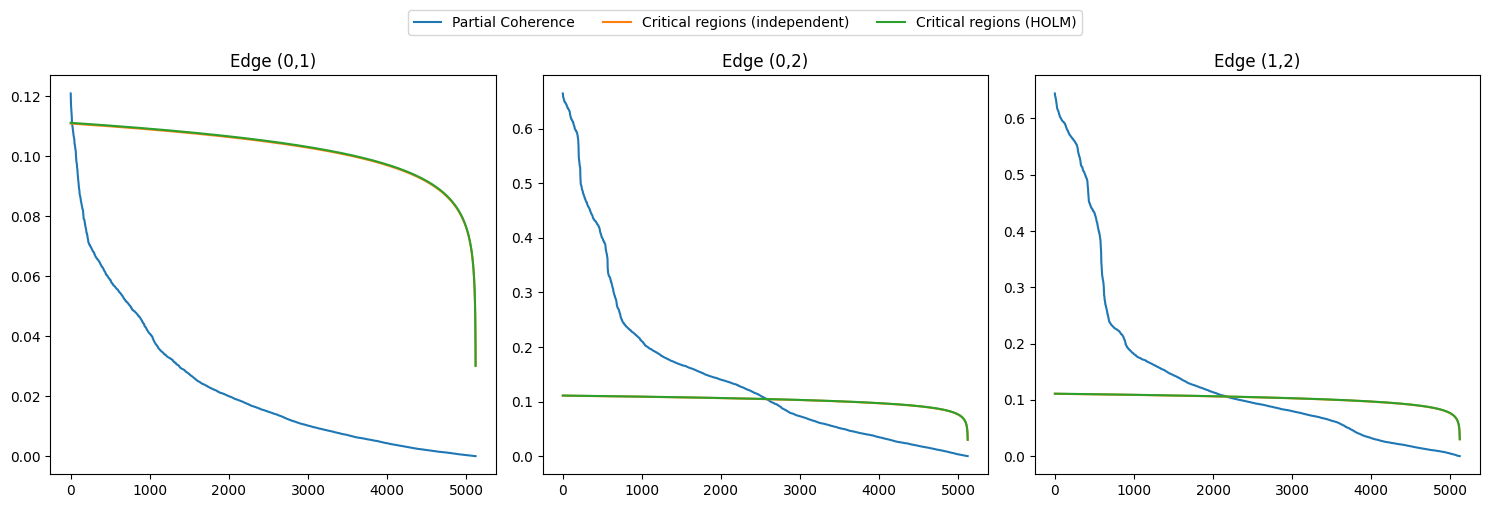

{(0, 1): np.float64(0.0), (0, 2): np.float64(0.5), (1, 2): np.float64(0.42)}
------
M value: 200


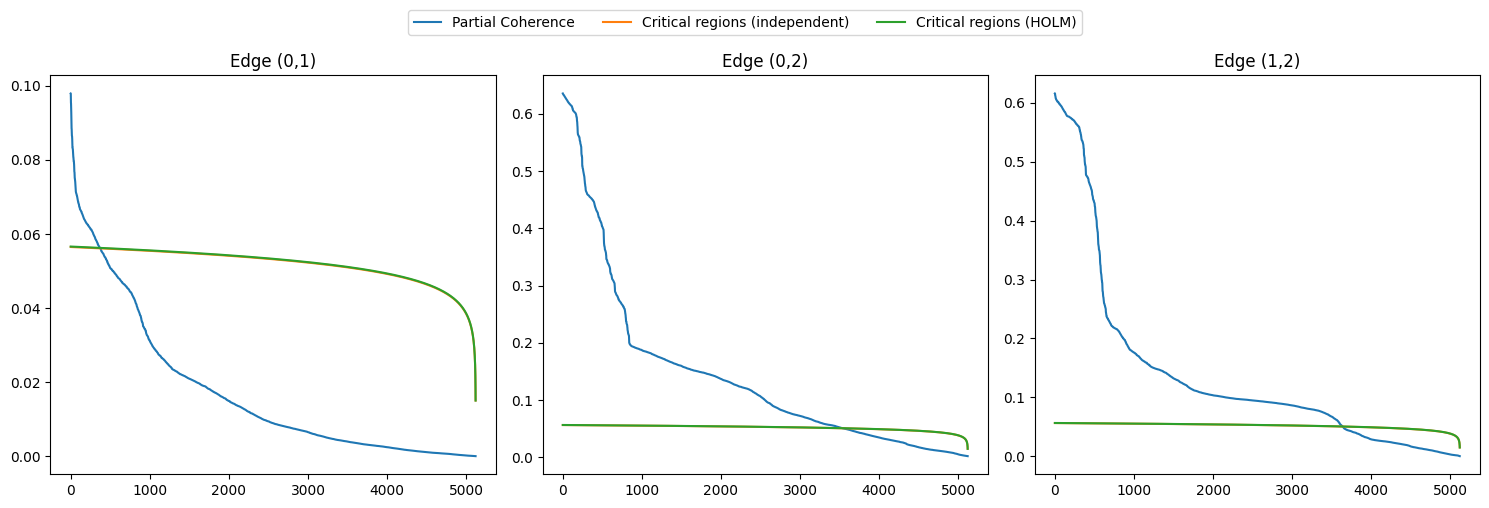

{(0, 1): np.float64(0.07), (0, 2): np.float64(0.69), (1, 2): np.float64(0.71)}
------


In [486]:
A_list = [np.array([
    [0.5, 0.0, 0.3],
    [0.0, 0.5, -0.3],
    [0.3, -0.3, 0.5]
])]

T = 10240
alpha = 0.05
m_list = [10, 30, 50, 100, 200]

# Transform each element to the desired format
names = [f'm={m}' for m in m_list]
names = ['Periodogram'] + names
T_0_list, partial_coherence_list, periodogram, frequencies = temporary_third_algoritm(A_list, T, alpha=alpha)

In [ ]:
plot_sdf_with_theoretical(frequencies,[periodogram] + T_0_list, names, theoretical_sdf=None, log_scale=False,
                          function=np.abs, different_frequencies=None)

In [ ]:
# coherence_P = calculate_partial_coherence(periodogram)
plot_sdf_with_theoretical(frequencies, partial_coherence_list, names[1:], theoretical_sdf=None, log_scale=False,
                          function=np.abs, different_frequencies=None)

In [535]:
import os
import json
import numpy as np
import pickle
from datetime import datetime
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt


def simulate_maximin_stepdown_test_one_edge_m(A_list, T, m, edge, alpha=0.05):
    """
    Perform the maximin stepdown hypothesis testing procedure.

    Parameters:
    coherence_matrix (numpy.ndarray): Coherence matrix with shape (p, p, num_freq).
    alpha (float): Significance level.
    n (int): Number of complex degrees of freedom (tapers)
    p (int): Number of time series.
    m (int): Number of tapers.

    Returns:
    int: Number of hypotheses under the critical value.
    """
    # Generate time series
    x = generate_var_process(A_list, T, 1000, seed=None)
    x = x - np.mean(x, axis=1, keepdims=True)
    
    # _, periodogram = calculate_periodogram(x)
    
    frequencies, T_0 = sinusoidal_multitaper_sdf_matrix(x, m)
    
    partial_coherence = calculate_partial_coherence(T_0)
    
    
    num_series, _, num_frequencies = partial_coherence.shape
    
    # Initialize an array to store the critical values for each frequency bin
    # critical_values = np.zeros(num_frequencies)
    
    # # Calculate critical values for each frequency bin
    # for l in range(1, num_frequencies + 1):
    #     critical_values[l - 1] = calculate_critical_region_minmax(alpha, num_frequencies, l, m, num_series)
        
    critical_values_holm = np.zeros(num_frequencies)
    # Calculate critical values for each frequency bin
    for l in range(1, num_frequencies + 1):
        critical_values_holm[l - 1] = calculate_critical_region_holm(alpha, num_frequencies, l, m, num_series)
        
    j, k = edge
    R_l = partial_coherence[j, k, :]
    R_ordered = np.sort(R_l)[::-1]
    comparison = R_ordered > critical_values_holm  # Check where R_ordered is greater than critical_values
    comparison = np.sum(comparison)
    ans = np.round(comparison / num_frequencies, 2)

    return ans   
    
def process_item(item, A_list, T, m, edge, alpha):
    ans = simulate_maximin_stepdown_test_one_edge_m(A_list, T, m, edge, alpha)
    return ans

def directory_exists(base_dir, dir_name):
    existing_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    for existing_dir in existing_dirs:
        if existing_dir.startswith(dir_name):
            return os.path.join(base_dir, existing_dir)
    return None

def load_simulation_results(directory_path):
    
    directory_path = '../third_algorithm_simulations/' + directory_path
    
    # Construct file paths
    config_file_path = os.path.join(directory_path, 'simulation_config.json')
    results_file_path = os.path.join(directory_path, 'results_per_m.pkl')
    
    # Load configuration
    with open(config_file_path, 'r') as file:
        config = json.load(file)
    
    # Load results
    with open(results_file_path, 'rb') as file:
        results_per_m = pickle.load(file)
    
    return config, results_per_m

def plot_simulation_results(config, results_per_m, path=None):
    """
    Plots the percentage of results not equal to zero and the average results per iteration
    for different m values. Optionally saves the plots to the specified path.

    Parameters:
    config (dict): Configuration dictionary containing 'm_list' and 'delta'.
    results_per_m (dict): Dictionary containing results for different m values.
    path (str, optional): Directory path to save the plots. If None, plots are not saved.

    Returns:
    None
    """
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot 1: Percentage of Results Not Equal to Zero
    for m in config['m_list']:
        percent_zero_results = [(np.array(results) != 0).mean() * 100 for results in results_per_m[m]]
        ax1.plot(np.arange(0, len(percent_zero_results) * config['delta'], config['delta']), percent_zero_results, label=f'm={m}')

    ax1.axhline(y=5, color='k', linestyle='--', label='5% threshold')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Percentage of Results Not Equal to Zero (%)')
    ax1.set_title('Percentage of Results Not Equal to Zero per Iteration for Different m Values')
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Average Results per Iteration
    for m in config['m_list']:
        averaged_results = [np.mean(results) for results in results_per_m[m]]
        ax2.plot(np.arange(0, len(averaged_results) * config['delta'], config['delta']), averaged_results, label=f'm={m}')

    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Average Result')
    ax2.set_title('Average Results per Iteration for Different m Values')
    ax2.legend()
    ax2.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save or show the plots
    if path is not None:
        if not os.path.exists(path):
            os.makedirs(path, exist_ok=True)
        plot_file_path = os.path.join(path, 'simulation_results.png')
        plt.savefig(plot_file_path)
        print(f"Plots saved to {plot_file_path}")
    else:
        plt.show()
        
def run_simulation_and_save_results(config, max_value=50, num_simulations=1000, force_save=False, tag = ""):
    m_list = config['m_list']
    T = config["T"]
    alpha = config['alpha']
    delta = config['delta']
    addition_term = np.array(config['addition_term'])
    initial_A_list = [np.array(config['initial_A_list'])]
    edge = config['edge']
    
    # Create a directory name excluding the timestamp
    dir_name_without_timestamp = f'size={initial_A_list[0].shape[0]}_T={T}_n={num_simulations}_max={max_value}'
    
    # Set path to the neighbor directory
    base_dir = '../third_algorithm_simulations'
    
    # Check if a directory with the same name (excluding timestamp) exists
    existing_dir_path = directory_exists(base_dir, dir_name_without_timestamp)
    if existing_dir_path and not force_save:
        print(f"Directory with the same configuration already exists: {existing_dir_path}")
        # Load the existing results
        config_file_path = os.path.join(existing_dir_path, 'simulation_config.json')
        results_file_path = os.path.join(existing_dir_path, 'results_per_m.pkl')
        
        with open(config_file_path, 'r') as file:
            loaded_config = json.load(file)
        
        with open(results_file_path, 'rb') as file:
            results_per_m = pickle.load(file)
        
        print(f"Loaded existing results from {existing_dir_path}")
        return loaded_config, results_per_m
    
    # Create a new directory with timestamp
    timestamp = datetime.now().strftime('%Y.%m.%d_%H:%M:%S')
    dir_name = f'{dir_name_without_timestamp}_{timestamp}'
    full_dir_path = os.path.join(base_dir, dir_name) + tag # TODO: Chenge the name here
    os.makedirs(full_dir_path, exist_ok=True)
    
    results_per_m = dict()

    for m in m_list:
        print(f"Processing m = {m}")
        results_list = []
        
        A_list = initial_A_list.copy()

        for i in range(max_value):
            items = range(num_simulations)  # Example list of items to process
            try:
            # Parallelize the for loop
                results = Parallel(n_jobs=-1)(
                    delayed(process_item)(item, A_list, T, m, edge, alpha=alpha) 
                    for item in tqdm(items, desc=f"Processing items for m={m}, iteration={i+1}")
                )
                results_list.append(results)
            except Exception as e:
                print(f"An error occurred during iteration {i+1} for m={m}: {e}")
                results_list.append([])  # Append empty results to maintain list structure in case of error
    
            A_list[0] = A_list[0] + delta * addition_term
        
        results_per_m[m] = results_list
    
    # Save the configuration to a JSON file
    config_file_path = os.path.join(full_dir_path, 'simulation_config.json')
    with open(config_file_path, 'w') as file:
        json.dump(config, file, indent=4)
    
    # Save the results to a file
    results_file_path = os.path.join(full_dir_path, 'results_per_m.pkl')
    with open(results_file_path, 'wb') as file:
        pickle.dump(results_per_m, file)
        
    # save figure
    plot_simulation_results(config, results_per_m, path=full_dir_path)
    
    print(f"Results saved in directory: {full_dir_path}")

    return config, results_per_m

In [476]:
# Example usage
delta = 0.02

addition_term = np.array([
    [0.0, 1, 0.0, 0.0, 0.0],
    [1, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])

# addition_term = np.array([
#     [0.0, 1, 0.0],
#     [1, 0.0, 0.0],
#     [0.0, 0.0, 0.0],
# ])

initial_A_list = np.array([
    [0.3, 0.0, 0.0, -0.2, 0.2],
    [0.0, 0.3, 0.2, 0.2, 0.2],
    [0.0, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.5]
])

# initial_A_list = np.array([
#     [0.5, 0.0, 0.0, 0.0, 0.0],
#     [0.0, 0.5, 0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.5, 0.0, 0.0],
#     [0.0, 0.0, 0.0, 0.5, 0.0],
#     [0.0, 0.0, 0.0, 0.0, 0.5]
# ])

# initial_A_list = np.array([
#     [0.3, 0.0, -0.3],
#     [0.0, 0.3, -0.4],
#     [-0.3, -0.4, 0.3],
# ])


# initial_A_list = np.array([
#     [0.2, 0.0, 0.3, 0.0, 0.3],
#     [0.0, -0.2, 0.0, 0.0, 0.0],
#     [0.2, 0.0, 0.3, 0.0, 0.0],
#     [0.2, 0.2, 0.0, 0.3, 0.0],
#     [0.2, 0.0, 0.2, 0.2, 0.2]
# ])





m_list = [10, 20, 50, 100, 200]
edge = (0, 1)

T = 8192
alpha = 0.05


# Configuration parameters
config = {
    "T": T,
    "alpha": alpha,
    "delta": delta,
    "addition_term": addition_term.tolist(),  # Convert NumPy array to list
    "m_list": m_list,
    "initial_A_list": initial_A_list.tolist(),  # Convert NumPy array to list
    "edge": edge
}

config, results_per_m = run_simulation_and_save_results(config, max_value=25, num_simulations=1000, force_save=True)

In [540]:
def expand_matrix(matrix, new_size, diag_value=0.5):
    """
    Expands a given matrix to a specified size and sets new diagonal elements to a specified value.
    
    Parameters:
    matrix (np.ndarray): The original matrix to expand.
    new_size (int): The desired size of the expanded matrix.
    diag_value (float): The value to set for the new diagonal elements.
    
    Returns:
    np.ndarray: The expanded matrix with new diagonal elements set to the specified value.
    """
    # Get the original size of the matrix
    original_size = matrix.shape[0]
    
    # Ensure the new size is larger than the original size
    if new_size < original_size:
        raise ValueError("New size must be larger than the original size.")
    
    # Create a new matrix of zeros with the desired size
    expanded_matrix = np.zeros((new_size, new_size))
    
    # Copy the original matrix into the top-left corner of the new matrix
    expanded_matrix[:original_size, :original_size] = matrix
    
    # Set the new diagonal elements to the specified value
    for i in range(original_size, new_size):
        expanded_matrix[i, i] = diag_value
    
    return expanded_matrix

# Example usage
initial_A_list = np.array([
    [0.3, 0.0, 0.0, -0.2, 0.2],
    [0.0, 0.3, 0.2, 0.2, 0.2],
    [0.0, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.5]
])

expanded_matrix = expand_matrix(initial_A_list, 5)
print(expanded_matrix)

[[ 0.3  0.   0.  -0.2  0.2]
 [ 0.   0.3  0.2  0.2  0.2]
 [ 0.   0.2  0.3 -0.2  0.2]
 [-0.2  0.2 -0.2  0.3  0.2]
 [ 0.2 -0.2  0.2  0.2  0.5]]


Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:07<00:00, 126.98it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:08<00:00, 112.33it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:10<00:00, 95.43it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:14<00:00, 68.34it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:27<00:00, 36.38it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=4096_n=1000_max=25_2024.07.24_11:04:46_complex/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=4096_n=1000_max=25_2024.07.24_11:04:46_complex
Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:14<00:00, 66.78it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:16<00:00, 60.33it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:20<00:00, 49.24it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:29<00:00, 33.72it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:46<00:00, 21.72it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=8192_n=1000_max=25_2024.07.24_11:34:49_complex/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=8192_n=1000_max=25_2024.07.24_11:34:49_complex


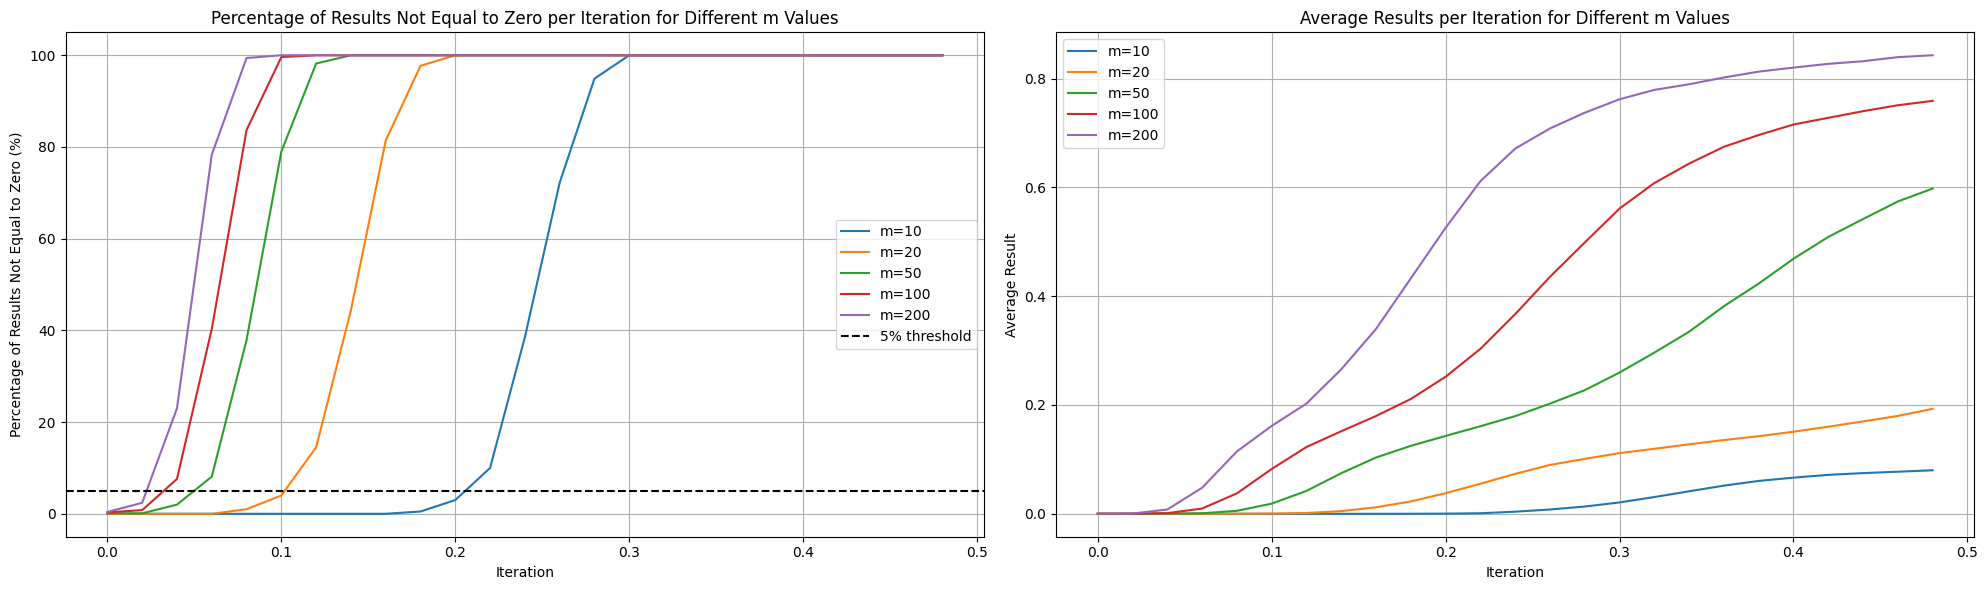

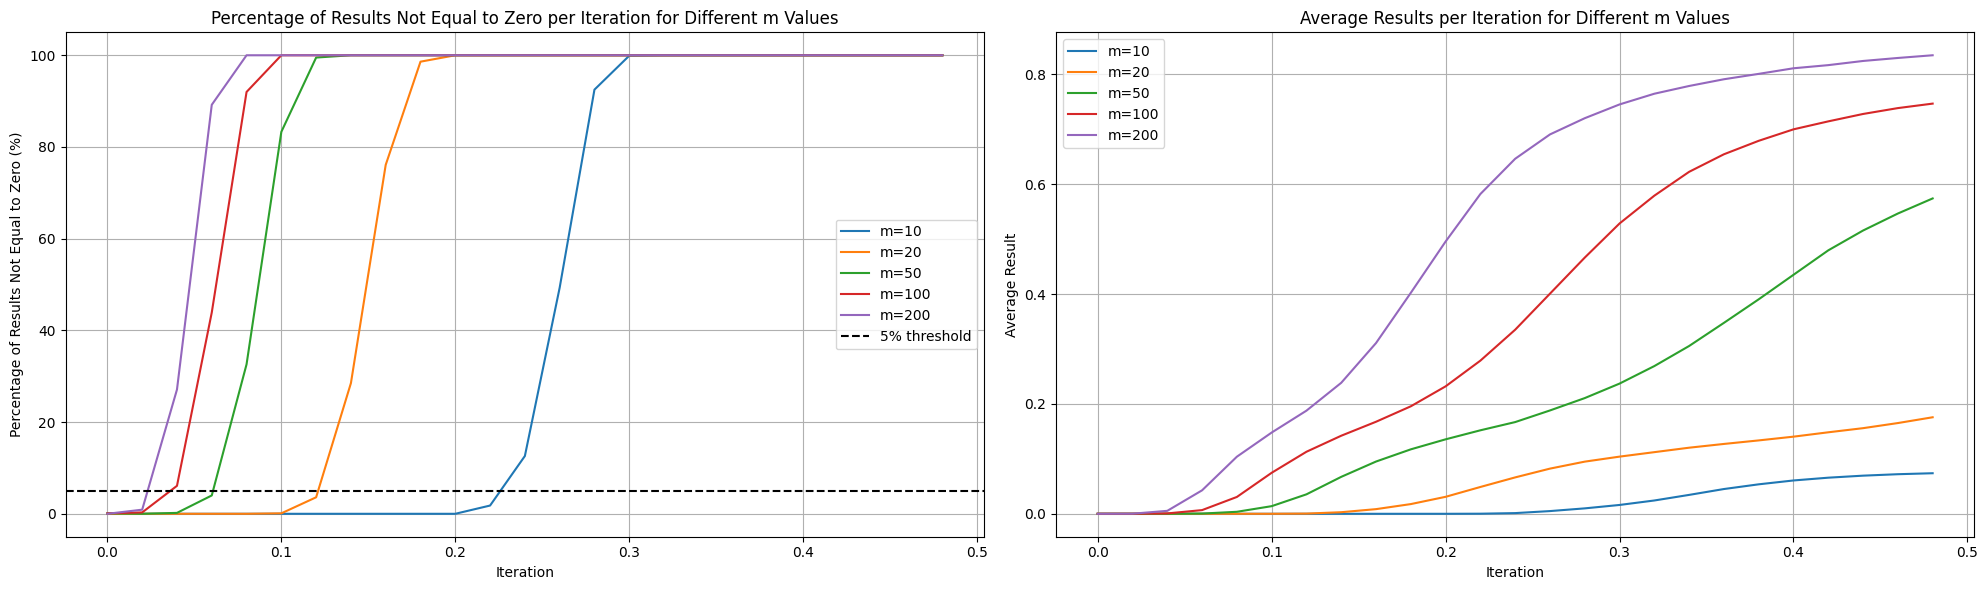

In [541]:
import time

delta = 0.02
m_list = [10, 20, 50, 100, 200]
edge = (0, 1)
alpha = 0.05

# initial_A_list = np.array([
#     [0.3, 0.0, 0.0, -0.2, 0.2],
#     [0.0, 0.3, 0.2, 0.2, 0.2],
#     [0.0, 0.2, 0.3, -0.2, 0.2],
#     [-0.2, 0.2, -0.2, 0.3, 0.2],
#     [0.2, -0.2, 0.2, 0.2, 0.5]
# ])

initial_A_list = np.array([
    [0.5, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.5, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.5, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.5]
])

addition_term = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])


T_list = [4096, 8192]
size_list = [5]


for size in size_list:
    for T in T_list:
        expanded_initial_A_list = expand_matrix(initial_A_list, size, diag_value=0.5)
        expanded_addition_term = expand_matrix(addition_term, size, diag_value=0.0)
        
        config = {
            "T": T,
            "alpha": alpha,
            "delta": delta,
            "addition_term": expanded_addition_term.tolist(),  # Convert NumPy array to list
            "m_list": m_list,
            "initial_A_list": expanded_initial_A_list.tolist(),  # Convert NumPy array to list
            "edge": edge
        }
        
        try:
            _, _ = run_simulation_and_save_results(config, max_value=25, num_simulations=1000, force_save=True,
                                                   tag='_complex')
        except Exception as e:
            print(f"An error occurred for T={T}, size={size}: {e}")

        # Pause for 60 seconds
        # time.sleep(60)
        
             
    

Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:01<00:00, 525.62it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:02<00:00, 473.06it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:03<00:00, 323.64it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:04<00:00, 222.51it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:07<00:00, 126.44it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=1024_n=1000_max=25_2024.07.24_12:32:00_complex_2/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=1024_n=1000_max=25_2024.07.24_12:32:00_complex_2
Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:03<00:00, 256.78it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:04<00:00, 240.41it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:05<00:00, 190.99it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:07<00:00, 133.20it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:12<00:00, 83.24it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=2048_n=1000_max=25_2024.07.24_12:41:00_complex_2/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=2048_n=1000_max=25_2024.07.24_12:41:00_complex_2
Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:07<00:00, 131.49it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:08<00:00, 122.76it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:10<00:00, 99.23it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:14<00:00, 69.03it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:26<00:00, 38.39it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=4096_n=1000_max=25_2024.07.24_12:55:30_complex_2/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=4096_n=1000_max=25_2024.07.24_12:55:30_complex_2
Processing m = 10


Processing items for m=10, iteration=25: 100%|██████████| 1000/1000 [00:15<00:00, 64.67it/s]


Processing m = 20


Processing items for m=20, iteration=25: 100%|██████████| 1000/1000 [00:17<00:00, 58.20it/s]


Processing m = 50


Processing items for m=50, iteration=25: 100%|██████████| 1000/1000 [00:19<00:00, 51.39it/s]


Processing m = 100


Processing items for m=100, iteration=25: 100%|██████████| 1000/1000 [00:30<00:00, 33.12it/s]


Processing m = 200


Processing items for m=200, iteration=25: 100%|██████████| 1000/1000 [00:50<00:00, 19.80it/s]


Plots saved to ../third_algorithm_simulations/size=5_T=8192_n=1000_max=25_2024.07.24_13:24:24_complex_2/simulation_results.png
Results saved in directory: ../third_algorithm_simulations/size=5_T=8192_n=1000_max=25_2024.07.24_13:24:24_complex_2


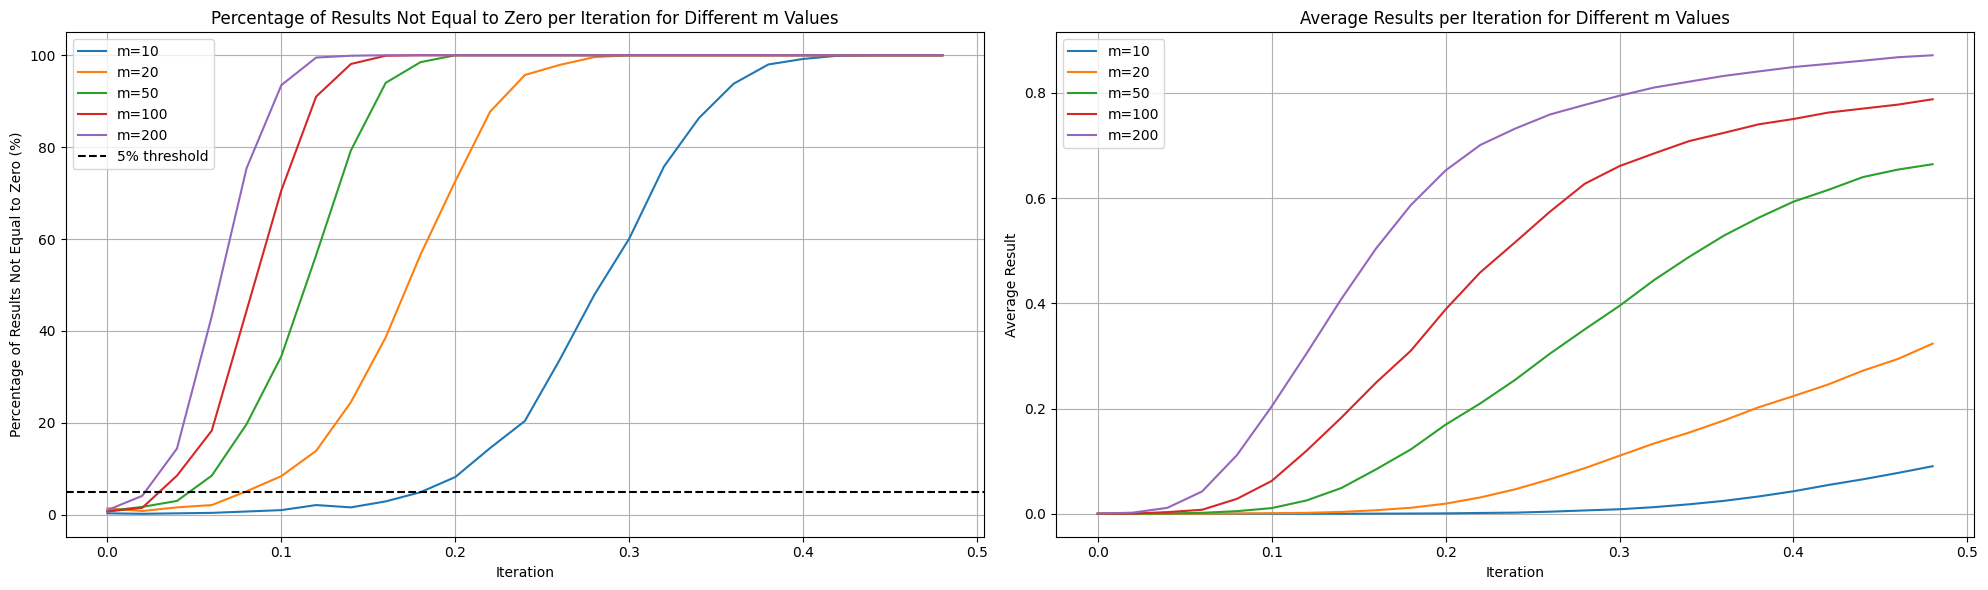

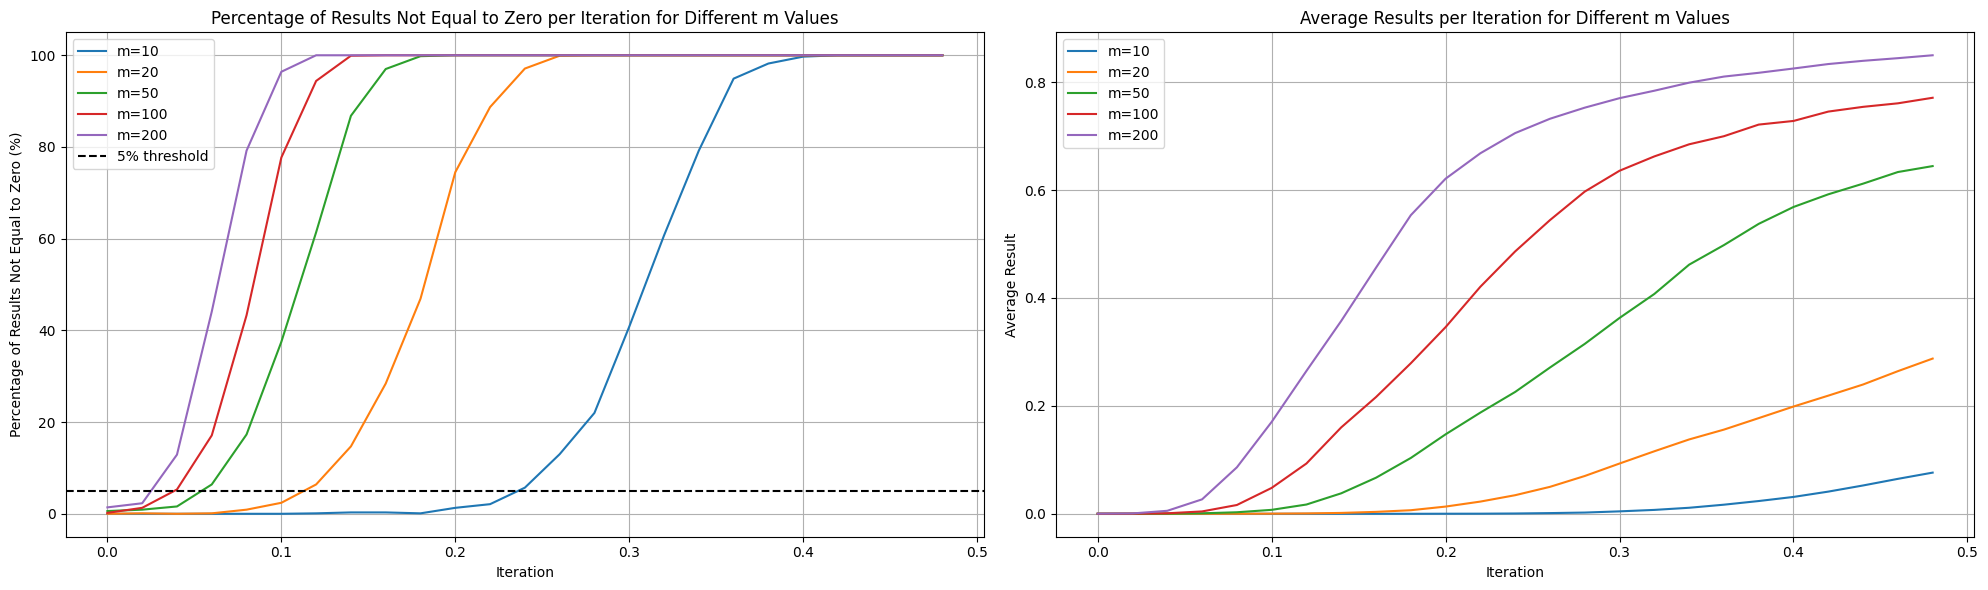

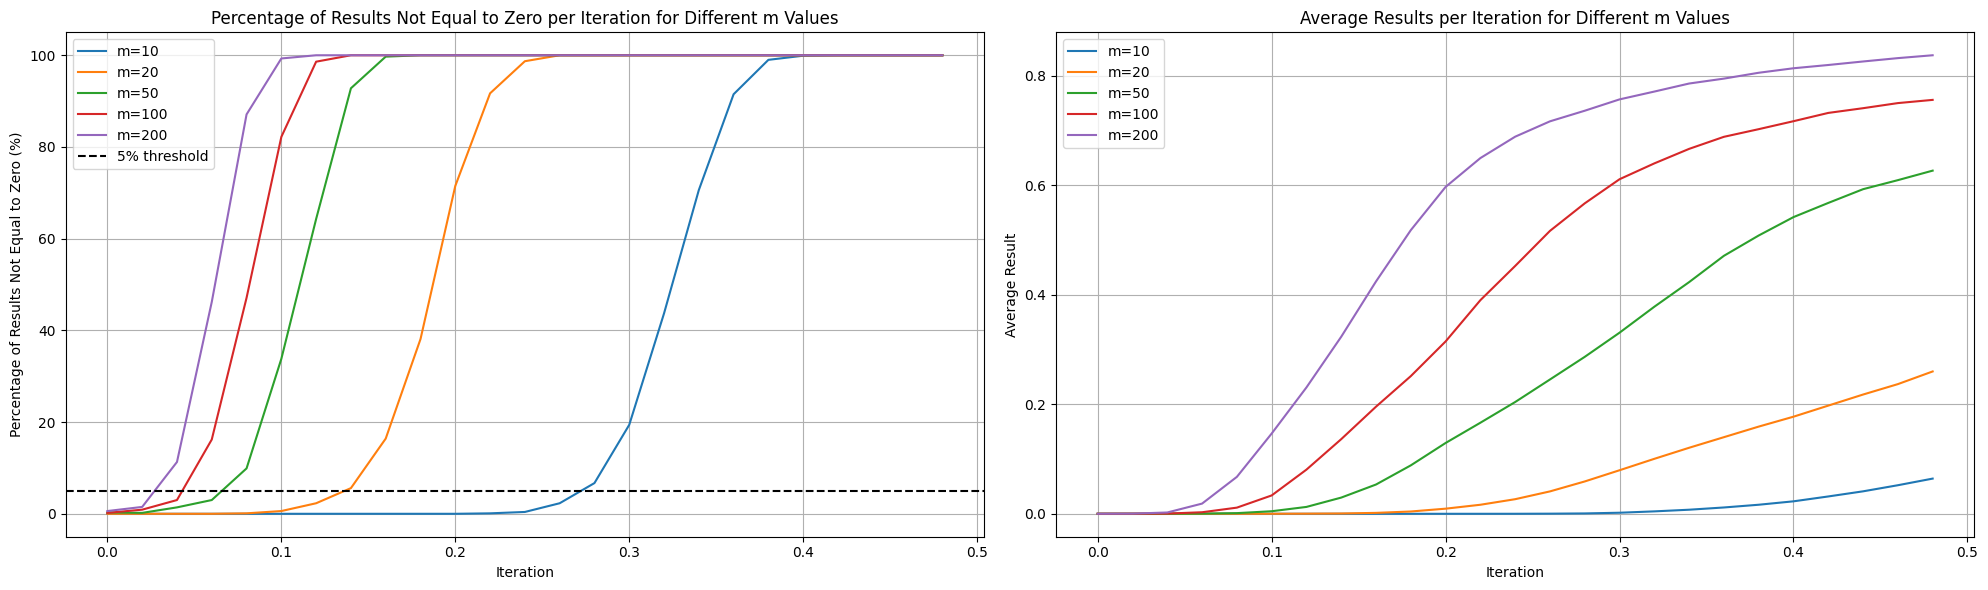

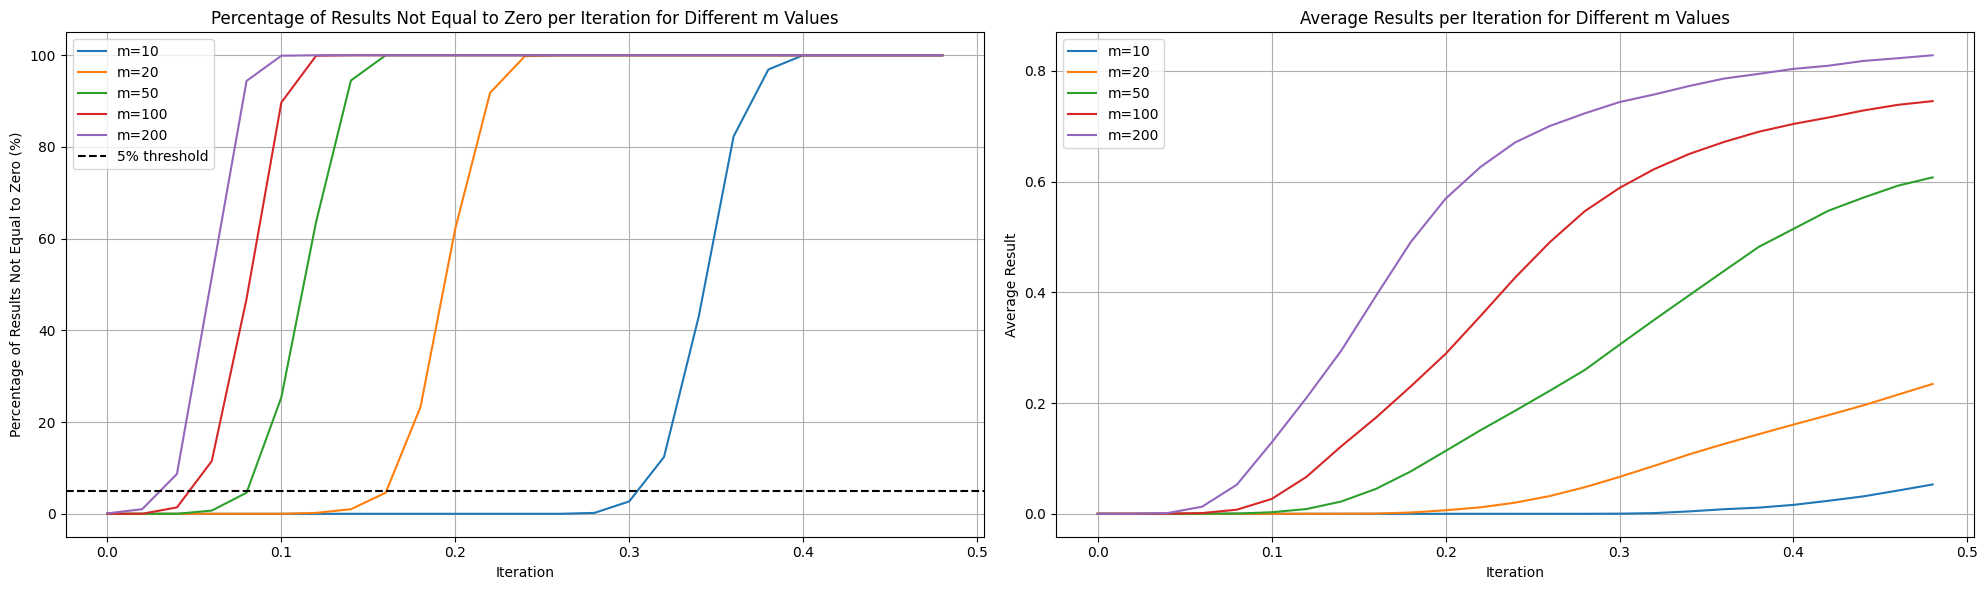

In [542]:
import time

delta = 0.02
m_list = [10, 20, 50, 100, 200]
edge = (0, 1)
alpha = 0.05

# initial_A_list = np.array([
#     [0.3, 0.0, 0.0, -0.2, 0.2],
#     [0.0, 0.3, 0.2, 0.2, 0.2],
#     [0.0, 0.2, 0.3, -0.2, 0.2],
#     [-0.2, 0.2, -0.2, 0.3, 0.2],
#     [0.2, -0.2, 0.2, 0.2, 0.5]
# ])

initial_A_list = np.array([
    [0.3, 0.0, 0.0, -0.5, 0.2],
    [0.0, 0.3, 0.2, 0.2, 0.5],
    [0.0, 0.0, 0.3, -0.2, 0.2],
    [0.0, 0.0, 0.0, 0.3, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.3]
])

addition_term = np.array([
    [0.0, 1.0, 0.0, 0.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0]
])


T_list = [1024, 2048, 4096, 8192]
size_list = [5]


for size in size_list:
    for T in T_list:
        expanded_initial_A_list = expand_matrix(initial_A_list, size, diag_value=0.5)
        expanded_addition_term = expand_matrix(addition_term, size, diag_value=0.0)
        
        config = {
            "T": T,
            "alpha": alpha,
            "delta": delta,
            "addition_term": expanded_addition_term.tolist(),  # Convert NumPy array to list
            "m_list": m_list,
            "initial_A_list": expanded_initial_A_list.tolist(),  # Convert NumPy array to list
            "edge": edge
        }
        
        try:
            _, _ = run_simulation_and_save_results(config, max_value=25, num_simulations=1000, force_save=True,
                                                   tag='_complex_2')
        except Exception as e:
            print(f"An error occurred for T={T}, size={size}: {e}")

In [537]:
process_item('haha', A_list=[expanded_initial_A_list], T=1024, m=10, edge=edge, alpha=alpha)

np.float64(0.0)

In [304]:
initial_A_list = [np.array([
    [0.3, 0.0, 0.0, -0.2, 0.2],
    [0.0, 0.3, 0.2, 0.2, 0.2],
    [0.0, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.5]
])]

is_var_process_stationary(initial_A_list)

Companion matrix: 
[[-0.3 -0.  -0.   0.2 -0.2]
 [-0.  -0.3 -0.2 -0.2 -0.2]
 [-0.  -0.2 -0.3  0.2 -0.2]
 [ 0.2 -0.2  0.2 -0.3 -0.2]
 [-0.2  0.2 -0.2 -0.2 -0.5]]
eigenvalues
[ 0.2321497 +0.j         -0.20942523+0.j         -0.61136224+0.05138082j
 -0.61136224-0.05138082j -0.5       +0.j        ]


np.True_

In [513]:
expanded_initial_A_list.shape

(10, 10)

In [514]:
def plot_time_series(x):
    """
    Plot the time series on one graph using Plotly.

    Parameters:
    x (numpy.ndarray): The generated time series.

    Returns:
    go.Figure: The Plotly figure object.
    """
    T = x.shape[1]
    num_series = x.shape[0]
    time = np.arange(T)

    fig = go.Figure()
    
    for i in range(num_series):
        fig.add_trace(go.Scatter(x=time, y=x[i], mode='lines', name=f'x{i+1}_t'))

    fig.update_layout(
        # title='Time Series',
        xaxis_title='Time',
        yaxis_title='Values',
        legend=dict(title='Series'),
        template='plotly_white'
    )

    return fig

In [ ]:
initial_A_list = [np.array([
    [0.3, 0.5, 0.0, -0.2, 0.2],
    [0.5, 0.3, 0.2, 0.2, 0.2],
    [0.0, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.3]
])]


x = generate_var_process([expanded_initial_A_list], 1024, burn_in=100, seed=None)
x = x - np.mean(x, axis=1, keepdims=True)

plot_time_series(x)

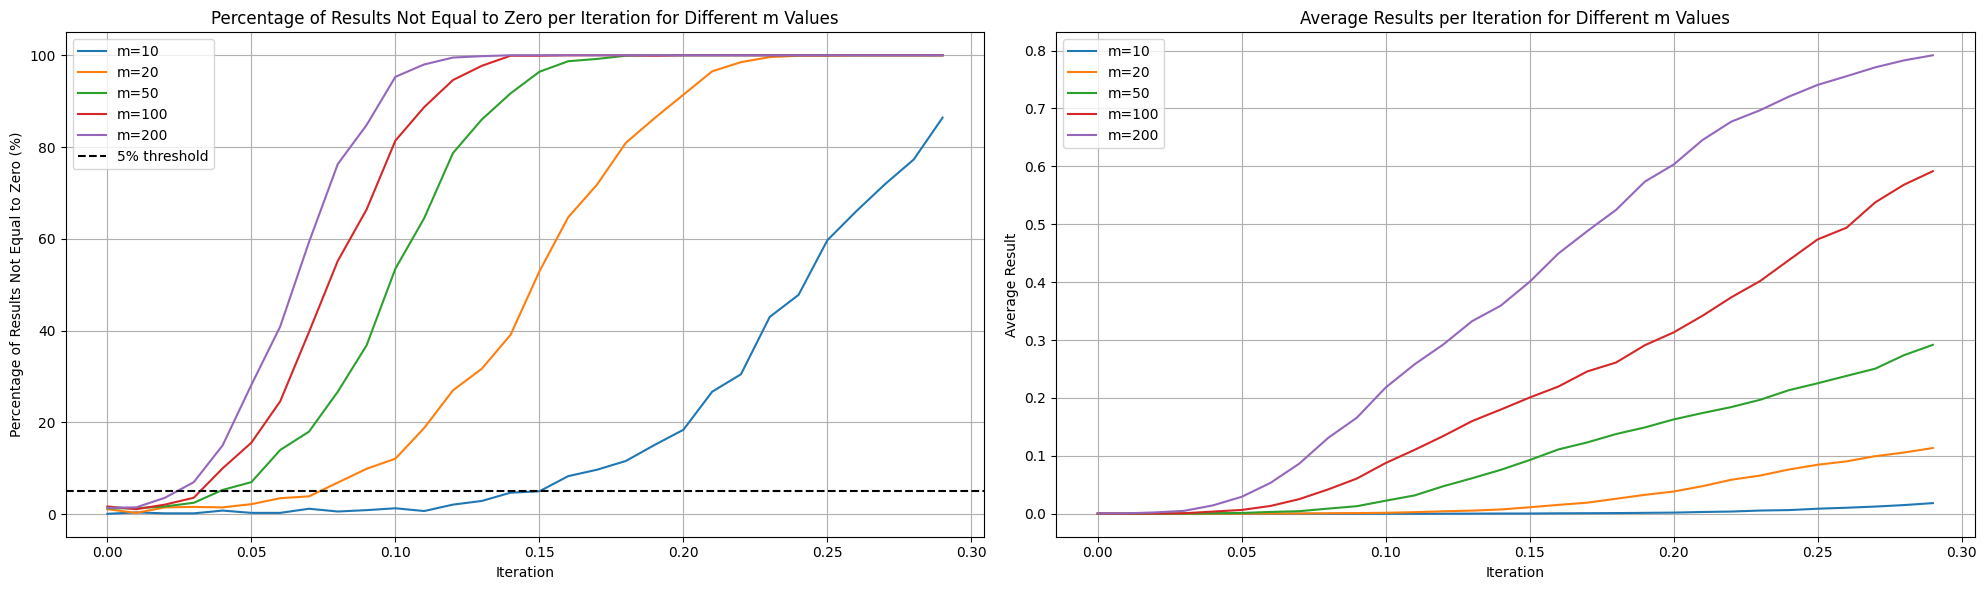

In [85]:
plot_simulation_results(config, results_per_m)

In [88]:
A_list = [np.array([
    [0.3, 0.49, 0.0, -0.2, 0.2],
    [0.49, 0.3, 0.2, 0.2, 0.2],
    [0.0, 0.2, 0.3, -0.2, 0.2],
    [-0.2, 0.2, -0.2, 0.3, 0.2],
    [0.2, -0.2, 0.2, 0.2, 0.5]
])]

is_var_process_stationary(A_list)

Companion matrix: 
[[-0.3  -0.49 -0.    0.2  -0.2 ]
 [-0.49 -0.3  -0.2  -0.2  -0.2 ]
 [-0.   -0.2  -0.3   0.2  -0.2 ]
 [ 0.2  -0.2   0.2  -0.3  -0.2 ]
 [-0.2   0.2  -0.2  -0.2  -0.5 ]]
eigenvalues
[ 0.44656755 -0.86904458 -0.21090207 -0.56662091 -0.5       ]


np.True_

In [278]:
import inspect

# Replace 'step_m' with the name of your function
print(inspect.getsource(simulate_maximin_stepdown_test_one_edge_m))

def simulate_maximin_stepdown_test_one_edge_m(A_list, T, m, edge, alpha=0.05):
    """
    Perform the maximin stepdown hypothesis testing procedure.

    Parameters:
    coherence_matrix (numpy.ndarray): Coherence matrix with shape (p, p, num_freq).
    alpha (float): Significance level.
    n (int): Number of complex degrees of freedom (tapers)
    p (int): Number of time series.
    m (int): Number of tapers.

    Returns:
    int: Number of hypotheses under the critical value.
    """
    # Generate time series
    x = generate_var_process(A_list, T, 1000, seed=None)
    x = x - np.mean(x, axis=1, keepdims=True)
    
    _, periodogram = calculate_periodogram(x)
    
    frequencies, T_0 = sinusoidal_multitaper_sdf_matrix(x, m)
    
    partial_coherence = calculate_partial_coherence(T_0)
    
    
    num_series, _, num_frequencies = partial_coherence.shape
    
    # Initialize an array to store the critical values for each frequency bin
    # critical_values = np.zeros(num_frequ

In [283]:
def get_simulation_directories_third_algorithm(base_dir='../third_algorithm_simulations'):
    """
    List all directories starting with 'size' from the given base directory.

    Parameters:
    base_dir (str): The base directory to search in. Defaults to '../third_algorithm_simulations'.

    Returns:
    list: A list of directory names starting with 'size'.
    """
    # Ensure the base directory exists
    if not os.path.exists(base_dir):
        raise ValueError(f"The base directory '{base_dir}' does not exist.")

    # List all directories starting with 'size'
    directories = [base_dir + '/' + name for name in os.listdir(base_dir)
                   if os.path.isdir(os.path.join(base_dir, name)) and name.startswith('size')]

    return directories

In [284]:
get_simulation_directories_third_algorithm()

['../third_algorithm_simulations/size=3_T=1024_n=1000_max=50_2024.07.22_17:29:45',
 '../third_algorithm_simulations/size=5_T=4096_n=1000_max=30_2024.07.23_10:41:53_complex',
 '../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:45:22_independent',
 '../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:14:35_complex',
 '../third_algorithm_simulations/size=3_T=1024_n=1000_max=30_2024.07.22_18:24:58',
 '../third_algorithm_simulations/size=5_T=1024_n=1000_max=50_2024.07.20_19:34:59_complex',
 '../third_algorithm_simulations/size=5_T=1024_n=1000_max=50_2024.07.20.18:41:53_independent',
 '../third_algorithm_simulations/size=5_T=1024_n=1000_max=30_2024.07.20_19:22:13_one_add',
 '../third_algorithm_simulations/size=3_T=2048_n=1000_max=30_2024.07.22_18:32:33']

In [286]:
def extract_T_from_path(path):
    """
    Extract the T value from the directory path.

    Parameters:
    path (str): The directory path.

    Returns:
    str: The extracted T value.
    """
    base_name = os.path.basename(path)
    T_value = base_name.split('_')[1].split('=')[1]
    return T_value

extract_T_from_path('../third_algorithm_simulations/size=3_T=1024_n=1000_max=50_2024.07.22_17:29:45')

'1024'

In [539]:
def categorize_directories(directories):
    categories = {}

    for dir in directories:
        # Extract the size from the directory name
        size_part = dir.split('size=')[1].split('_')[0]
        
        # Determine the base category
        if 'independent' in dir:
            base_category = 'independent'
        elif 'one_add' in dir:
            base_category = 'add_one'
        elif 'complex' in dir:
            base_category = 'complex'
        else:
            base_category = 'other'

        # Create the final category name
        category = f"{base_category}_{size_part}"
        
        # Add the directory to the appropriate category
        if category not in categories:
            categories[category] = []
        categories[category].append(dir)

    return categories

# Example usage
directories = [
    '../third_algorithm_simulations/size=3_T=1024_n=1000_max=50_2024.07.22_17:29:45',
    '../third_algorithm_simulations/size=5_T=4096_n=1000_max=30_2024.07.23_10:41:53_complex',
    '../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:45:22_independent',
    '../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:14:35_complex',
    '../third_algorithm_simulations/size=3_T=1024_n=1000_max=30_2024.07.22_18:24:58',
    '../third_algorithm_simulations/size=7_T=1024_n=1000_max=50_2024.07.20_19:34:59_complex',
    '../third_algorithm_simulations/size=5_T=1024_n=1000_max=50_2024.07.20.18:41:53_independent',
    '../third_algorithm_simulations/size=5_T=1024_n=1000_max=30_2024.07.20_19:22:13_one_add',
    '../third_algorithm_simulations/size=3_T=2048_n=1000_max=30_2024.07.22_18:32:33'
]

categories = categorize_directories(directories)
for category, dirs in categories.items():
    print(f"{category}:")
    for d in dirs:
        print(f"  {d}")

other_3:
  ../third_algorithm_simulations/size=3_T=1024_n=1000_max=50_2024.07.22_17:29:45
  ../third_algorithm_simulations/size=3_T=1024_n=1000_max=30_2024.07.22_18:24:58
  ../third_algorithm_simulations/size=3_T=2048_n=1000_max=30_2024.07.22_18:32:33
complex_5:
  ../third_algorithm_simulations/size=5_T=4096_n=1000_max=30_2024.07.23_10:41:53_complex
  ../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:14:35_complex
independent_5:
  ../third_algorithm_simulations/size=5_T=2048_n=1000_max=50_2024.07.22_16:45:22_independent
  ../third_algorithm_simulations/size=5_T=1024_n=1000_max=50_2024.07.20.18:41:53_independent
complex_7:
  ../third_algorithm_simulations/size=7_T=1024_n=1000_max=50_2024.07.20_19:34:59_complex
add_one_5:
  ../third_algorithm_simulations/size=5_T=1024_n=1000_max=30_2024.07.20_19:22:13_one_add
